In [1]:
import torch; import torch.nn as nn; from torch.optim import lr_scheduler
import torch.optim as optim
import torch.backends.cudnn as cudnn 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [2]:
data_transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_folder = { x : datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform[x])
                 for x in ['train', 'val']}
dataloaders = { x : torch.utils.data.DataLoader(image_folder[x], shuffle=True, 
                                                batch_size=4, num_workers=4)
               for x in ['train', 'val']}
dataset_size = {x : len(image_folder[x])
                for x in ['train', 'val']}
class_names = image_folder['train'].classes
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available else 'cpu'
print(f"Using {device} device")

Using cuda device


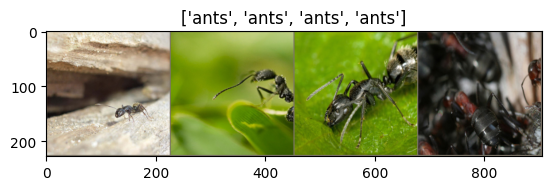

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.486, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, labels = next(iter(dataloaders['train'])) 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in labels])


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            # Each epoch has a training and validation phase 
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.0
                running_correct = 0
                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward 
                    # track history only if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimizer only if training phase 
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    #@ stadistics
                    running_loss =+ loss.item() * inputs.size(0)
                    running_correct += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_size[phase]
                epoch_acc = running_correct.double() / dataset_size[phase]

                print(f'{phase} Loss : {epoch_loss: .4f} Acc : {epoch_acc:.4f} ')    
                
                if phase == 'val' and epoch_acc > best_acc:
                    torch.save(model.state_dict(), best_model_params_path)

            print()
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
        print(f'Best val Acc {best_acc:4f}')
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model 

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted : {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 
                
        model.train(model=was_training)


In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss :  0.0033 Acc : 0.6885 
val Loss :  0.0057 Acc : 0.8497 

Epoch 1/24
----------
train Loss :  0.0010 Acc : 0.7500 
val Loss :  0.0001 Acc : 0.9216 

Epoch 2/24
----------
train Loss :  0.0053 Acc : 0.8484 
val Loss :  0.0000 Acc : 0.8954 

Epoch 3/24
----------
train Loss :  0.0070 Acc : 0.7705 
val Loss :  0.0144 Acc : 0.8366 

Epoch 4/24
----------
train Loss :  0.0004 Acc : 0.8115 
val Loss :  0.0000 Acc : 0.9020 

Epoch 5/24
----------
train Loss :  0.0015 Acc : 0.8361 
val Loss :  0.0006 Acc : 0.8366 

Epoch 6/24
----------
train Loss :  0.0158 Acc : 0.8402 
val Loss :  0.0002 Acc : 0.8627 

Epoch 7/24
----------
train Loss :  0.0028 Acc : 0.8484 
val Loss :  0.0000 Acc : 0.8889 

Epoch 8/24
----------
train Loss :  0.0004 Acc : 0.8484 
val Loss :  0.0007 Acc : 0.9020 

Epoch 9/24
----------
train Loss :  0.0054 Acc : 0.8811 
val Loss :  0.0014 Acc : 0.9020 

Epoch 10/24
----------
train Loss :  0.0087 Acc : 0.8852 
val Loss :  0.0000 Acc : 0.9085 

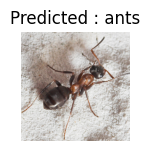

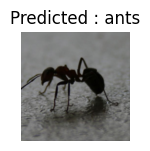

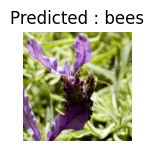

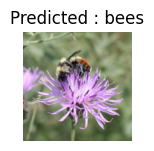

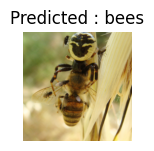

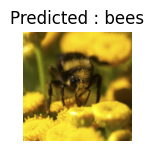

In [14]:
visualize_model(model_ft)

In [15]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for parameter in model_conv.parameters():
    parameter.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss :  0.0331 Acc : 0.5738 
val Loss :  0.0012 Acc : 0.7974 

Epoch 1/24
----------
train Loss :  0.0042 Acc : 0.8033 
val Loss :  0.0001 Acc : 0.9412 

Epoch 2/24
----------
train Loss :  0.0063 Acc : 0.7951 
val Loss :  0.0000 Acc : 0.9150 

Epoch 3/24
----------
train Loss :  0.0060 Acc : 0.8607 
val Loss :  0.0016 Acc : 0.9608 

Epoch 4/24
----------
train Loss :  0.0077 Acc : 0.7418 
val Loss :  0.0000 Acc : 0.9346 

Epoch 5/24
----------
train Loss :  0.0060 Acc : 0.7951 
val Loss :  0.0005 Acc : 0.9542 

Epoch 6/24
----------
train Loss :  0.0023 Acc : 0.8074 
val Loss :  0.0000 Acc : 0.8889 

Epoch 7/24
----------
train Loss :  0.0056 Acc : 0.8484 
val Loss :  0.0001 Acc : 0.9477 

Epoch 8/24
----------
train Loss :  0.0055 Acc : 0.8279 
val Loss :  0.0012 Acc : 0.9542 

Epoch 9/24
----------
train Loss :  0.0011 Acc : 0.8238 
val Loss :  0.0000 Acc : 0.9412 

Epoch 10/24
----------
train Loss :  0.0002 Acc : 0.8402 
val Loss :  0.0000 Acc : 0.9477 

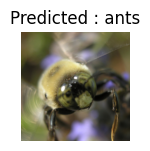

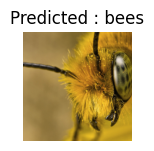

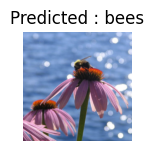

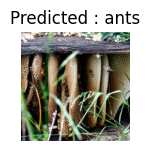

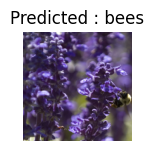

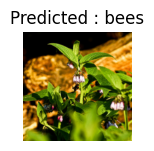

In [17]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [19]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transform['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

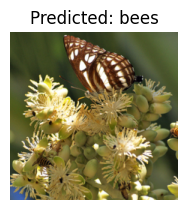

In [20]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()